In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

In [12]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)
data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

In [13]:
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']]
y = data['closePrice']

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

def create_lstm_dataset(X, y, time_step=1):
    X_lstm, y_lstm = [], []
    for i in range(time_step, len(X)):
        X_lstm.append(X[i-time_step:i])
        y_lstm.append(y[i])
    return np.array(X_lstm), np.array(y_lstm)

time_step = 3  # Выбираем 3 временных шага для LSTM
X_train_lstm, y_train_lstm = create_lstm_dataset(X_train, y_train, time_step)
X_test_lstm, y_test_lstm = create_lstm_dataset(X_test, y_test, time_step)

In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

D:\financial_time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0861 - val_loss: 0.0029
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_lo

In [16]:
y_pred_lstm = model.predict(X_test_lstm)

y_test_actual = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))
y_pred_actual = scaler_y.inverse_transform(y_pred_lstm)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [17]:
mse_lstm = mean_squared_error(y_test_actual, y_pred_actual)
print(f'Mean Squared Error for LSTM: {mse_lstm}')

Mean Squared Error for LSTM: 7114116.60494782


In [21]:
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 4.74%


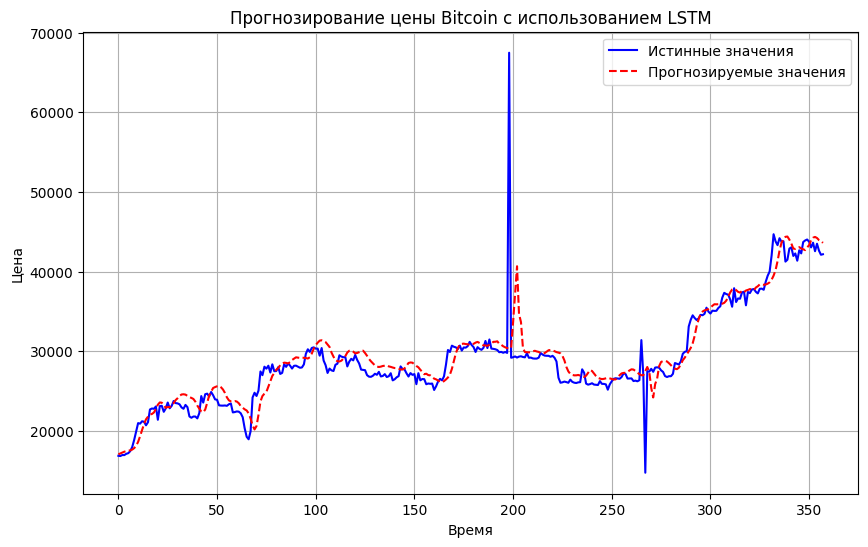

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Истинные значения')
plt.plot(y_pred_actual, color='red', label='Прогнозируемые значения', linestyle='--')
plt.legend()
plt.title('Прогнозирование цены Bitcoin с использованием LSTM')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

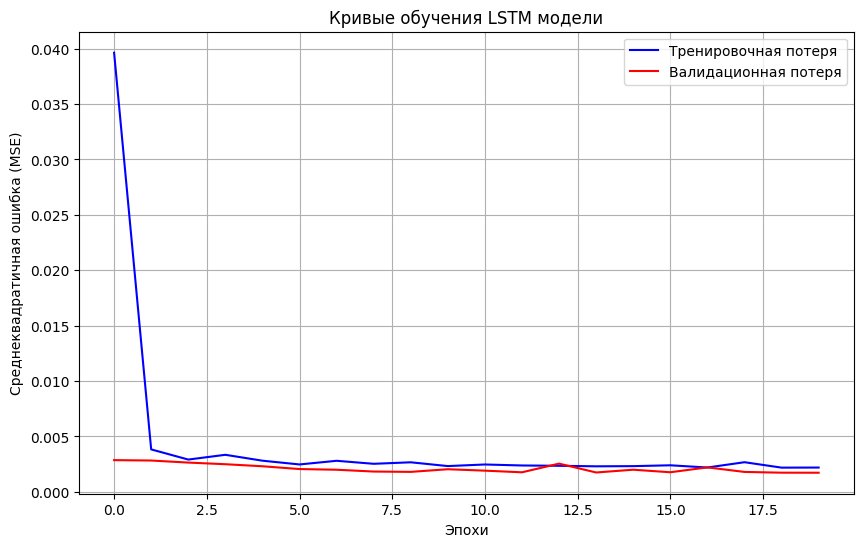

In [20]:
# 16. Построение графика кривых обучения
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='blue', label='Тренировочная потеря')
plt.plot(history.history['val_loss'], color='red', label='Валидационная потеря')
plt.title('Кривые обучения LSTM модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()